# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [95]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

In [96]:
# from fastai.structured import *
# from fastai.column_data import *
# np.set_printoptions(threshold=50, edgeitems=20)

PATH='/home/navneet/train_amex/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [97]:
train = pd.read_csv(PATH+'train.csv',parse_dates=['DateTime'],index_col='DateTime').sort_index()
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['hour'] = train.index.hour
train['minute'] = train.index.minute
print('Done with train')
historical = pd.read_csv(PATH+'historical_user_logs.csv',parse_dates=['DateTime'],index_col='DateTime').sort_index()
historical.columns = ['user_id','product','action']
historical = pd.get_dummies(data=historical,columns=['action'])
print('Done with Historical')

#train.drop('DateTime', axis =1,inplace =True)
x = historical.groupby(['user_id','product']).agg({'action_interest':'sum','action_view':'sum'}).reset_index()
print(x.columns)
x.head()

Done with train
Done with Historical
Index(['user_id', 'product', 'action_interest', 'action_view'], dtype='object')


,user_id,product,action_interest,action_view
0,4,A,0,3.0
1,4,B,0,1.0
2,4,H,0,1.0
3,4,I,0,2.0
4,19,A,0,14.0


In [98]:
train = train.merge(x, how = 'left', on =['user_id', 'product'])

In [99]:
print(train.shape)
train.head()

(463291, 21)


,session_id,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,...,city_development_index,var_1,is_click,year,month,day,hour,minute,action_interest,action_view
0,140690,858557,C,359520,13787,4,NaN,10.0,Female,4.0,...,3.0,0,0,2017,7,2,0,0,0.0,5.0
1,333291,243253,C,105960,11085,5,NaN,8.0,Female,2.0,...,NaN,0,0,2017,7,2,0,0,0.0,11.0
2,129781,243253,C,359520,13787,4,NaN,8.0,Female,2.0,...,NaN,0,0,2017,7,2,0,0,0.0,11.0
3,464848,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,...,2.0,1,0,2017,7,2,0,0,1.0,8.0
4,90569,663656,C,405490,60305,3,NaN,2.0,Male,2.0,...,2.0,1,0,2017,7,2,0,1,0.0,3.0


In [100]:
train.action_view.fillna(0, inplace =True)
train.action_interest.fillna(0, inplace =True)

Then set null values from elapsed field calculations to 0.

In [101]:
train.columns

Index(['session_id', 'user_id', 'product', 'campaign_id', 'webpage_id',
       'product_category_1', 'product_category_2', 'user_group_id', 'gender',
       'age_level', 'user_depth', 'city_development_index', 'var_1',
       'is_click', 'year', 'month', 'day', 'hour', 'minute', 'action_interest',
       'action_view'],
      dtype='object')

In [102]:
train.dtypes

session_id                  int64
user_id                     int64
product                    object
campaign_id                 int64
webpage_id                  int64
product_category_1          int64
product_category_2        float64
user_group_id             float64
gender                     object
age_level                 float64
user_depth                float64
city_development_index    float64
var_1                       int64
is_click                    int64
year                        int64
month                       int64
day                         int64
hour                        int64
minute                      int64
action_interest           float64
action_view               float64
dtype: object

In [103]:
from torch.utils.data import Dataset, DataLoader


class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None,num_cols= None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = num_cols + [output_col]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

In [104]:
train.fillna(method = 'bfill', inplace = True)

In [105]:
categorical_features = ['product', 'campaign_id','webpage_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
output_feature = "is_click"

from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for cat_col in categorical_features:
    label_encoders[cat_col] = LabelEncoder()
    train[cat_col] = label_encoders[cat_col].fit_transform(train[cat_col])



#cat_vars = ['product', 'campaign_id','webpage_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
contin_vars = ['product_category_1', 'day', 'month']# 'hour', 'minute', 'action_interest', 'action_view']
#n = len(train); n

In [106]:
train.head()

,session_id,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,...,city_development_index,var_1,is_click,year,month,day,hour,minute,action_interest,action_view
0,140690,858557,2,4,3,4,270915.0,10.0,0,4,...,2,0,0,2017,7,2,0,0,0.0,5.0
1,333291,243253,2,2,2,5,270915.0,8.0,0,2,...,1,0,0,2017,7,2,0,0,0.0,11.0
2,129781,243253,2,4,3,4,270915.0,8.0,0,2,...,1,0,0,2017,7,2,0,0,0.0,11.0
3,464848,1097446,8,4,3,3,270915.0,3.0,1,3,...,1,1,0,2017,7,2,0,0,1.0,8.0
4,90569,663656,2,8,8,3,270915.0,2.0,1,2,...,1,1,0,2017,7,2,0,1,0.0,3.0


In [107]:
train.drop(['session_id', 'user_id'], axis =1 , inplace =True)


In [108]:
train_val_index = int(0.8*train.shape[0])
new_train = train[:train_val_index]
new_valid = train[train_val_index:]
print(new_train.shape)
print(new_valid.shape)

(370632, 19)
(92659, 19)


In [109]:
train.shape

(463291, 19)

In [110]:
dataset1 = TabularDataset(data=new_train, cat_cols=categorical_features,num_cols= contin_vars, 
                             output_col=output_feature)
dataset2 = TabularDataset(data=new_valid, cat_cols=categorical_features,num_cols= contin_vars, 
                             output_col=output_feature)

In [111]:
batchsize = 200
dataloader1 = DataLoader(dataset1, batchsize, shuffle=True, num_workers=1)
dataloader2 = DataLoader(dataset2, batchsize, shuffle=True, num_workers=1)

In [112]:
cat_dims = [int(train[col].nunique()) for col in categorical_features]
cat_dims

[10, 10, 9, 2, 7, 3, 4, 2]

In [113]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(10, 5), (10, 5), (9, 5), (2, 1), (7, 4), (3, 2), (4, 2), (2, 1)]

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
          x = F.relu(lin_layer(x))
          x = bn_layer(x)
          x = dropout_layer(x)
          #x = F.relu(x)

    x = self.output_layer(x)
    #x = F.sigmoid(x)

    return x

In [115]:
model = FeedForwardNN(emb_dims, no_of_cont=len(contin_vars)+1, lin_layer_sizes=[40, 20],
                          output_size=1, emb_dropout=0.4,
                          lin_layer_dropouts=[0.1,0.1])

In [116]:
len(dataloader)

7239

In [117]:
train.shape

(463291, 19)

In [118]:
# preddddd_list= []
# bredd_list = []
train_losses = []
test_losses = []
no_of_epochs = 4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(no_of_epochs):
    running_loss =0
    for y, cont_x, cat_x in dataloader1:

        cat_x = cat_x
        cont_x = cont_x
        y  = y

        # Forward Pass
        preds = model(cont_x, cat_x)
        #print(type(preds))
        loss = criterion(preds, y)
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
#         if epoch == no_of_epochs -1:
#             if i==7239:
#                 val_store = (y, cont_x, cat_x)
    #print(loss.item())
#     preddddd_list.append(preds)
#     bredd_list.append(y)
    
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for y2, cont_x2, cat_x2 in dataloader2:
                cat_x2 = cat_x2
                cont_x2 = cont_x2
                y2  = y2

        # Forward Pass
                preds2 = model(cont_x2, cat_x2)
        
                loss2 = criterion(preds2, y2)
                test_loss += loss2
                
                #ps = torch.exp(log_ps)
                #top_p, top_class = ps.topk(1, dim=1)
                top_class = (preds2.detach().numpy()>0.5)
                equals = top_class == y2.detach().numpy()
                accuracy += np.mean(equals)
                
        train_losses.append(running_loss/len(dataloader1))
        test_losses.append(test_loss/len(dataloader2))
        model.train()
        print(epoch,
              "Training Loss: {:.3f}.. ".format(running_loss/len(dataloader1)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(dataloader2)),
              "Test Accuracy: {:.3f}".format(accuracy/len(dataloader2)))

0 Training Loss: 0.011..  Test Loss: 0.000..  Test Accuracy: 1.000
1 Training Loss: 0.002..  Test Loss: 0.000..  Test Accuracy: 1.000
2 Training Loss: 0.002..  Test Loss: 0.000..  Test Accuracy: 1.000
3 Training Loss: 0.002..  Test Loss: 0.000..  Test Accuracy: 1.000


In [119]:
auzz = []
from sklearn.metrics import roc_auc_score
for y2, cont_x2, cat_x2 in dataloader2:
                cat_x2 = cat_x2
                cont_x2 = cont_x2
                y2  = y2

        
                preds2 = model(cont_x2, cat_x2)
                auz = (roc_auc_score((y2.detach().numpy()==1), (preds2.detach().numpy()>0.1)))
                auzz.append(auz)
                
np.mean(auzz)

0.9988299068603845

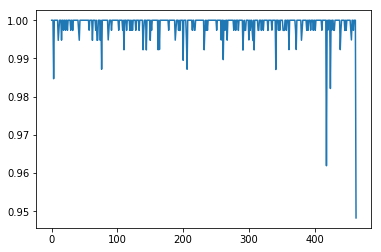

In [120]:
import matplotlib.pyplot as plt
plt.plot(auzz)

In [29]:
for i in range(5):
    print(((preddddd_list[i].detach().numpy()>0.5) == (bredd_list[i].detach().numpy()==1)).mean())

1.0
1.0
1.0
1.0
1.0


In [39]:
y_t, cont_x_t, cat_x_t = val_store

In [42]:
print(((model(cont_x,cat_x).detach().numpy()>0.5) == (y_t.detach().numpy()==1)).mean())
#model(cont_x,cat_x).detach().numpy()

1.0


/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [59]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [60]:
apply_cats(joined, joined)

In [61]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    #joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [ ]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [39]:
samp_size = n
#joined_samp = joined.set_index("Date")

We can now process our data...

In [32]:
joined.head(2)

,product,campaign_id,webpage_id,gender,age_level,user_depth,city_development_index,var_1,product_category_1,day,month,hour,minute,action_interest,action_view,is_click
0,C,359520,13787,Female,4.0,3.0,3.0,0,4.0,2.0,7.0,0.0,0.0,0.0,5.0,0
1,C,105960,11085,Female,2.0,2.0,NaN,0,5.0,2.0,7.0,0.0,0.0,0.0,11.0,0


In [62]:
df, y, nas, mapper = proc_df(joined, 'is_click', do_scale=True)
yl = y

In [63]:
def makeOverSamplesSMOTE(X,y):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
 from imblearn.over_sampling import SMOTE
 sm = SMOTE()
 X, y = sm.fit_sample(X, y)
 return X,y
df_numpy,yl_numpy = makeOverSamplesSMOTE(df,y = yl)
#

In [75]:
df_from_numpy = pd.DataFrame(df_numpy, columns = df.columns)
y_from_numpy = pd.DataFrame(yl, columns = ['is_click'])

In [77]:
y_from_numpy.columns

Index(['is_click'], dtype='object')

In [ ]:
joined_test = joined_test.set_index("Date")

In [ ]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [157]:
df.shape

(463291, 15)

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [88]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(df_from_numpy.shape[0] * train_ratio); train_size
val_idx = list(range(train_size, len(df_from_numpy)))

In [86]:
train_size

647940

In [90]:
len(val_idx)

215980

In [96]:
train_size + len(val_idx)

863920

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [35]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [32]:
val_idx=[0]

In [97]:
df_from_numpy.shape

(863920, 15)

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [72]:
def inv_y(a): return a

def nonu(y_pred, targ):
    #targ = inv_y(targ)
    #pct_var = (targ - inv_y(y_pred))
    loss = nn.BCELoss()
    return loss(y_pred,targ)

max_log_y = np.max(yl)
y_range = (0, 1)

In [46]:
joined.columns

Index(['product', 'campaign_id', 'webpage_id', 'gender', 'age_level',
       'user_depth', 'city_development_index', 'var_1', 'product_category_1',
       'day', 'month', 'hour', 'minute', 'action_interest', 'action_view',
       'is_click'],
      dtype='object')

In [47]:
# df = pd.DataFrame(df, columns = ['product', 'campaign_id', 'webpage_id', 'gender', 'age_level',
#        'user_depth', 'city_development_index', 'var_1', 'product_category_1',
#        'day', 'month', 'hour', 'minute', 'action_interest', 'action_view'] )
# yl = pd.DataFrame(yl, columns = ['is_click'])

In [92]:
df_from_numpy.head()

,product,campaign_id,webpage_id,gender,age_level,user_depth,city_development_index,var_1,product_category_1,day,month,hour,minute,action_interest,action_view
0,3.0,5.0,4.0,1.0,5.0,3.0,3.0,1.0,0.711203,-1.445784,0.0,-2.468141,-1.699591,-0.311179,-0.363172
1,3.0,3.0,3.0,1.0,3.0,2.0,0.0,1.0,1.477938,-1.445784,0.0,-2.468141,-1.699591,-0.311179,-0.234329
2,3.0,5.0,4.0,1.0,3.0,2.0,0.0,1.0,0.711203,-1.445784,0.0,-2.468141,-1.699591,-0.311179,-0.234329
3,9.0,5.0,4.0,2.0,4.0,3.0,2.0,2.0,-0.055533,-1.445784,0.0,-2.468141,-1.699591,0.577475,-0.298750
4,3.0,9.0,9.0,2.0,3.0,3.0,2.0,2.0,-0.055533,-1.445784,0.0,-2.468141,-1.641835,-0.311179,-0.406119


We can create a ModelData object directly from out data frame.

In [95]:
df = df_from_numpy.copy()
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y_from_numpy.astype(np.float32), cat_flds=cat_vars, bs=128,test_df=None)

ValueError: Item wrong length 863920 instead of 463291.

In [162]:
np.max(yl)

1

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [163]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [104]:
md??

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [164]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [165]:
emb_szs

[(11, 6), (11, 6), (10, 5), (3, 2), (8, 4), (4, 2), (5, 3), (3, 2)]

In [166]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 6]),
                           ('trainable', True),
                           ('nb_params', tensor(66))])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 6]),
                           ('trainable', True),
                           ('nb_params', tensor(66))])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 5]),
                           ('trainable', True),
                           ('nb_params', tensor(50))])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', tensor(6))])),
             ('Embedding-5',
              Ordere

In [106]:
m.lr_find??

In [167]:
lr = 1e-3
m.lr_find()

epoch      trn_loss   val_loss                                  
    0      0.070527   0.061439  


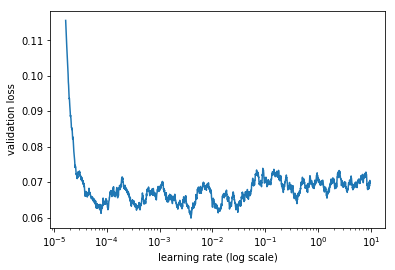

In [168]:
m.sched.plot(100)

### Sample

In [174]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.2, 1, [1000,800,500,200], [0.001,0.01,0.01,0.1], y_range=y_range)
lr = 1e-4

In [175]:
import warnings
warnings.filterwarnings('ignore')
m.fit(lr, 4, metrics=[nonu], cycle_len=1)

epoch      trn_loss   val_loss   nonu                           
    0      0.064482   0.057842   0.233333  
    1      0.065386   0.057758   0.23225                        
    2      0.065765   0.05774    0.232018                       
    3      0.066682   0.057693   0.231468                       
    4      0.059971   0.058137   0.237417                       
    5      0.068738   0.057741   0.231475                       
 18%|█▊        | 498/2715 [00:31<02:20, 15.77it/s, loss=0.0629]

KeyboardInterrupt: 

In [113]:
m.fit(lr, 2, metrics=[nonu], cycle_len=4)

epoch      trn_loss   val_loss   nonu                           
    0      0.065895   0.057736   0.231168  
    1      0.063315   0.057681   0.230747                       
 11%|█▏        | 308/2715 [00:12<01:36, 24.89it/s, loss=0.0629]

KeyboardInterrupt: 

### All

In [55]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [56]:
m.fit(lr, 1, metrics=[exp_rmspe])

  0%|          | 3/2715 [00:00<03:56, 11.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  0%|          | 9/2715 [00:00<02:49, 15.93it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  1%|          | 15/2715 [00:00<02:17, 19.65it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  1%|          | 21/2715 [00:00<01:57, 22.99it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  1%|          | 28/2715 [00:01<01:43, 25.99it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  1%|▏         | 34/2715 [00:01<01:39, 27.07it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  1%|▏         | 40/2715 [00:01<01:34, 28.42it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  2%|▏         | 46/2715 [00:01<01:40, 26.48it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  2%|▏         | 52/2715 [00:02<01:39, 26.71it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  2%|▏         | 55/2715 [00:02<01:44, 25.35it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  2%|▏         | 61/2715 [00:02<01:42, 25.89it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  2%|▏         | 67/2715 [00:02<01:40, 26.42it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  3%|▎         | 73/2715 [00:02<01:40, 26.22it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  3%|▎         | 79/2715 [00:03<01:40, 26.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  3%|▎         | 85/2715 [00:03<01:39, 26.48it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  3%|▎         | 92/2715 [00:03<01:40, 26.05it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  4%|▎         | 98/2715 [00:03<01:43, 25.23it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  4%|▎         | 101/2715 [00:03<01:44, 25.11it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  4%|▍         | 107/2715 [00:04<01:36, 27.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  4%|▍         | 116/2715 [00:04<01:35, 27.34it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  4%|▍         | 119/2715 [00:04<01:33, 27.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  5%|▍         | 128/2715 [00:04<01:32, 28.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  5%|▍         | 131/2715 [00:04<01:35, 27.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  5%|▌         | 140/2715 [00:05<01:29, 28.70it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  5%|▌         | 146/2715 [00:05<01:30, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  5%|▌         | 149/2715 [00:05<01:29, 28.62it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  6%|▌         | 155/2715 [00:05<01:30, 28.24it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  6%|▌         | 162/2715 [00:06<01:30, 28.22it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  6%|▌         | 168/2715 [00:06<01:28, 28.80it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  6%|▋         | 174/2715 [00:06<01:31, 27.76it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  7%|▋         | 180/2715 [00:06<01:31, 27.85it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  7%|▋         | 189/2715 [00:07<01:29, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  7%|▋         | 192/2715 [00:07<01:30, 27.97it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  7%|▋         | 198/2715 [00:07<01:29, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  8%|▊         | 204/2715 [00:07<01:29, 27.90it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  8%|▊         | 210/2715 [00:07<01:29, 28.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  8%|▊         | 219/2715 [00:08<01:27, 28.43it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  8%|▊         | 222/2715 [00:08<01:31, 27.34it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  8%|▊         | 228/2715 [00:08<01:28, 28.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  9%|▊         | 237/2715 [00:08<01:27, 28.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  9%|▉         | 240/2715 [00:08<01:26, 28.76it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  9%|▉         | 249/2715 [00:09<01:27, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

  9%|▉         | 252/2715 [00:09<01:29, 27.66it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 10%|▉         | 258/2715 [00:09<01:25, 28.74it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 10%|▉         | 265/2715 [00:09<01:25, 28.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 10%|█         | 272/2715 [00:09<01:25, 28.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 10%|█         | 278/2715 [00:10<01:23, 29.21it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 10%|█         | 284/2715 [00:10<01:24, 28.75it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 11%|█         | 290/2715 [00:10<01:23, 29.17it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 11%|█         | 296/2715 [00:10<01:25, 28.31it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 11%|█         | 302/2715 [00:11<01:27, 27.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 11%|█▏        | 308/2715 [00:11<01:24, 28.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 12%|█▏        | 314/2715 [00:11<01:28, 27.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 12%|█▏        | 320/2715 [00:11<01:24, 28.24it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 12%|█▏        | 326/2715 [00:11<01:24, 28.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 12%|█▏        | 332/2715 [00:12<01:26, 27.66it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 12%|█▏        | 338/2715 [00:12<01:25, 27.65it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 13%|█▎        | 345/2715 [00:12<01:25, 27.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 13%|█▎        | 351/2715 [00:12<01:27, 26.88it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 13%|█▎        | 357/2715 [00:13<01:24, 28.05it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 13%|█▎        | 361/2715 [00:13<01:23, 28.03it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 14%|█▎        | 367/2715 [00:13<01:21, 28.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 14%|█▍        | 374/2715 [00:13<01:21, 28.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 14%|█▍        | 381/2715 [00:13<01:23, 28.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 14%|█▍        | 387/2715 [00:14<01:22, 28.27it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 14%|█▍        | 393/2715 [00:14<01:24, 27.53it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 15%|█▍        | 399/2715 [00:14<01:20, 28.64it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 15%|█▍        | 406/2715 [00:14<01:20, 28.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 15%|█▌        | 409/2715 [00:14<01:20, 28.53it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 15%|█▌        | 416/2715 [00:15<01:19, 29.04it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 16%|█▌        | 422/2715 [00:15<01:21, 28.20it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 16%|█▌        | 428/2715 [00:15<01:19, 28.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 16%|█▌        | 435/2715 [00:15<01:18, 29.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 16%|█▌        | 441/2715 [00:15<01:19, 28.47it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 17%|█▋        | 449/2715 [00:16<01:15, 29.83it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 17%|█▋        | 455/2715 [00:16<01:17, 29.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 17%|█▋        | 461/2715 [00:16<01:19, 28.52it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 17%|█▋        | 468/2715 [00:16<01:16, 29.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 17%|█▋        | 474/2715 [00:17<01:18, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 18%|█▊        | 477/2715 [00:17<01:17, 28.83it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 18%|█▊        | 485/2715 [00:17<01:16, 29.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 18%|█▊        | 491/2715 [00:17<01:18, 28.34it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 18%|█▊        | 498/2715 [00:17<01:16, 29.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 19%|█▊        | 504/2715 [00:18<01:16, 28.72it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 19%|█▉        | 510/2715 [00:18<01:15, 29.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 19%|█▉        | 517/2715 [00:18<01:15, 29.02it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 19%|█▉        | 523/2715 [00:18<01:17, 28.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 19%|█▉        | 529/2715 [00:18<01:15, 28.95it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 20%|█▉        | 535/2715 [00:19<01:16, 28.31it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 20%|█▉        | 541/2715 [00:19<01:18, 27.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 20%|██        | 547/2715 [00:19<01:15, 28.62it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 20%|██        | 553/2715 [00:19<01:18, 27.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 21%|██        | 559/2715 [00:20<01:17, 27.99it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 21%|██        | 565/2715 [00:20<01:18, 27.55it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 21%|██        | 571/2715 [00:20<01:19, 26.95it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 21%|██▏       | 577/2715 [00:20<01:17, 27.42it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 21%|██▏       | 583/2715 [00:20<01:19, 26.66it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 22%|██▏       | 589/2715 [00:21<01:17, 27.53it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 22%|██▏       | 595/2715 [00:21<01:17, 27.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 22%|██▏       | 601/2715 [00:21<01:17, 27.20it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 22%|██▏       | 608/2715 [00:21<01:14, 28.47it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 23%|██▎       | 614/2715 [00:22<01:13, 28.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 23%|██▎       | 620/2715 [00:22<01:12, 29.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 23%|██▎       | 626/2715 [00:22<01:13, 28.30it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 23%|██▎       | 632/2715 [00:22<01:16, 27.27it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 24%|██▎       | 639/2715 [00:22<01:11, 29.02it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 24%|██▍       | 645/2715 [00:23<01:12, 28.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 24%|██▍       | 651/2715 [00:23<01:13, 28.14it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 24%|██▍       | 657/2715 [00:23<01:11, 28.81it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 24%|██▍       | 663/2715 [00:23<01:12, 28.25it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 25%|██▍       | 667/2715 [00:23<01:11, 28.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 25%|██▍       | 675/2715 [00:24<01:07, 30.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 25%|██▌       | 681/2715 [00:24<01:10, 29.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 25%|██▌       | 688/2715 [00:24<01:11, 28.49it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 26%|██▌       | 694/2715 [00:24<01:11, 28.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 26%|██▌       | 700/2715 [00:25<01:11, 28.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 26%|██▌       | 707/2715 [00:25<01:10, 28.30it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 26%|██▋       | 713/2715 [00:25<01:11, 28.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 26%|██▋       | 719/2715 [00:25<01:10, 28.21it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 27%|██▋       | 725/2715 [00:25<01:13, 27.19it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 27%|██▋       | 731/2715 [00:26<01:12, 27.40it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 27%|██▋       | 737/2715 [00:26<01:11, 27.75it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 27%|██▋       | 743/2715 [00:26<01:11, 27.49it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 28%|██▊       | 749/2715 [00:26<01:09, 28.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 28%|██▊       | 756/2715 [00:27<01:07, 29.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 28%|██▊       | 762/2715 [00:27<01:08, 28.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 28%|██▊       | 768/2715 [00:27<01:06, 29.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 29%|██▊       | 775/2715 [00:27<01:07, 28.63it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 29%|██▉       | 782/2715 [00:27<01:05, 29.30it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 29%|██▉       | 788/2715 [00:28<01:05, 29.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 29%|██▉       | 791/2715 [00:28<01:08, 27.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 29%|██▉       | 798/2715 [00:28<01:06, 28.90it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 30%|██▉       | 807/2715 [00:28<01:06, 28.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 30%|██▉       | 810/2715 [00:28<01:05, 29.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 30%|███       | 816/2715 [00:29<01:08, 27.62it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 30%|███       | 822/2715 [00:29<01:10, 26.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 31%|███       | 829/2715 [00:29<01:07, 28.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 31%|███       | 836/2715 [00:29<01:06, 28.20it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 31%|███       | 843/2715 [00:30<01:07, 27.53it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 31%|███▏      | 850/2715 [00:30<01:05, 28.48it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 31%|███▏      | 853/2715 [00:30<01:07, 27.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 32%|███▏      | 861/2715 [00:30<01:06, 28.02it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 32%|███▏      | 867/2715 [00:30<01:04, 28.55it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 32%|███▏      | 873/2715 [00:31<01:05, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 32%|███▏      | 879/2715 [00:31<01:03, 28.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 33%|███▎      | 885/2715 [00:31<01:04, 28.35it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 33%|███▎      | 891/2715 [00:31<01:05, 27.92it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 33%|███▎      | 897/2715 [00:32<01:02, 28.90it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 33%|███▎      | 903/2715 [00:32<01:03, 28.50it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 33%|███▎      | 909/2715 [00:32<01:02, 28.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 34%|███▎      | 915/2715 [00:32<01:03, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 34%|███▍      | 922/2715 [00:32<01:04, 27.88it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 34%|███▍      | 928/2715 [00:33<01:02, 28.80it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 34%|███▍      | 935/2715 [00:33<01:02, 28.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 35%|███▍      | 941/2715 [00:33<01:04, 27.64it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 35%|███▍      | 947/2715 [00:33<01:03, 27.88it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 35%|███▌      | 954/2715 [00:34<01:01, 28.50it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 35%|███▌      | 960/2715 [00:34<01:00, 28.99it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 36%|███▌      | 966/2715 [00:34<01:00, 28.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 36%|███▌      | 972/2715 [00:34<01:01, 28.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 36%|███▌      | 979/2715 [00:34<01:00, 28.93it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 36%|███▋      | 985/2715 [00:35<01:01, 28.28it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 37%|███▋      | 991/2715 [00:35<01:01, 27.96it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 37%|███▋      | 997/2715 [00:35<00:59, 28.77it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 37%|███▋      | 1003/2715 [00:35<01:01, 28.02it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 37%|███▋      | 1009/2715 [00:35<01:00, 28.40it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 37%|███▋      | 1015/2715 [00:36<01:01, 27.83it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 38%|███▊      | 1021/2715 [00:36<01:03, 26.54it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 38%|███▊      | 1027/2715 [00:36<01:00, 27.94it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 38%|███▊      | 1033/2715 [00:36<01:00, 27.71it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 38%|███▊      | 1039/2715 [00:37<00:58, 28.79it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 38%|███▊      | 1045/2715 [00:37<00:58, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 39%|███▊      | 1051/2715 [00:37<01:00, 27.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 39%|███▉      | 1057/2715 [00:37<00:58, 28.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 39%|███▉      | 1063/2715 [00:37<00:58, 28.11it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 39%|███▉      | 1070/2715 [00:38<00:57, 28.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 40%|███▉      | 1076/2715 [00:38<00:57, 28.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 40%|███▉      | 1082/2715 [00:38<00:59, 27.42it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 40%|████      | 1089/2715 [00:38<00:55, 29.41it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 40%|████      | 1095/2715 [00:38<00:56, 28.51it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 41%|████      | 1101/2715 [00:39<00:59, 27.18it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 41%|████      | 1107/2715 [00:39<00:57, 27.95it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 41%|████      | 1113/2715 [00:39<00:58, 27.28it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 41%|████      | 1119/2715 [00:39<00:56, 28.45it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 41%|████▏     | 1125/2715 [00:40<00:56, 28.31it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 42%|████▏     | 1131/2715 [00:40<00:57, 27.66it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 42%|████▏     | 1137/2715 [00:40<00:56, 28.17it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 42%|████▏     | 1143/2715 [00:40<00:56, 27.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 42%|████▏     | 1149/2715 [00:40<00:55, 27.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 43%|████▎     | 1155/2715 [00:41<00:55, 27.90it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 43%|████▎     | 1161/2715 [00:41<00:57, 27.18it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 43%|████▎     | 1167/2715 [00:41<00:54, 28.47it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 43%|████▎     | 1171/2715 [00:41<00:55, 28.03it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 43%|████▎     | 1178/2715 [00:41<00:53, 28.94it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 44%|████▎     | 1184/2715 [00:42<00:55, 27.81it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 44%|████▍     | 1190/2715 [00:42<00:53, 28.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 44%|████▍     | 1199/2715 [00:42<00:53, 28.25it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 44%|████▍     | 1202/2715 [00:42<00:54, 27.75it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 44%|████▍     | 1208/2715 [00:43<00:52, 28.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 45%|████▍     | 1214/2715 [00:43<00:52, 28.43it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 45%|████▍     | 1221/2715 [00:43<00:53, 27.77it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 45%|████▌     | 1227/2715 [00:43<00:52, 28.61it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 45%|████▌     | 1233/2715 [00:43<00:53, 27.52it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 46%|████▌     | 1239/2715 [00:44<00:52, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 46%|████▌     | 1245/2715 [00:44<00:53, 27.70it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 46%|████▌     | 1251/2715 [00:44<00:53, 27.16it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 46%|████▋     | 1257/2715 [00:44<00:51, 28.39it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 47%|████▋     | 1263/2715 [00:45<00:52, 27.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 47%|████▋     | 1270/2715 [00:45<00:50, 28.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 47%|████▋     | 1276/2715 [00:45<00:52, 27.61it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 47%|████▋     | 1282/2715 [00:45<00:52, 27.55it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 47%|████▋     | 1288/2715 [00:45<00:50, 28.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 48%|████▊     | 1294/2715 [00:46<00:51, 27.85it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 48%|████▊     | 1297/2715 [00:46<00:50, 27.96it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 48%|████▊     | 1305/2715 [00:46<00:49, 28.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 48%|████▊     | 1311/2715 [00:46<00:49, 28.25it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 49%|████▊     | 1320/2715 [00:47<00:47, 29.17it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 49%|████▊     | 1323/2715 [00:47<00:48, 28.61it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 49%|████▉     | 1330/2715 [00:47<00:47, 29.03it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 49%|████▉     | 1337/2715 [00:47<00:47, 28.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 50%|████▉     | 1346/2715 [00:47<00:48, 28.51it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 50%|████▉     | 1349/2715 [00:48<00:48, 28.41it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 50%|█████     | 1358/2715 [00:48<00:47, 28.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 50%|█████     | 1361/2715 [00:48<00:48, 27.65it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 50%|█████     | 1368/2715 [00:48<00:46, 28.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 51%|█████     | 1374/2715 [00:48<00:47, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 51%|█████     | 1380/2715 [00:49<00:46, 28.73it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 51%|█████     | 1386/2715 [00:49<00:46, 28.48it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 51%|█████▏    | 1392/2715 [00:49<00:47, 27.61it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 51%|█████▏    | 1398/2715 [00:49<00:45, 28.64it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 52%|█████▏    | 1405/2715 [00:50<00:45, 28.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 52%|█████▏    | 1411/2715 [00:50<00:45, 28.50it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 52%|█████▏    | 1417/2715 [00:50<00:46, 28.14it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 52%|█████▏    | 1423/2715 [00:50<00:47, 27.45it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 53%|█████▎    | 1429/2715 [00:50<00:45, 28.25it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 53%|█████▎    | 1435/2715 [00:51<00:46, 27.35it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 53%|█████▎    | 1441/2715 [00:51<00:45, 27.79it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 53%|█████▎    | 1447/2715 [00:51<00:44, 28.63it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 54%|█████▎    | 1453/2715 [00:51<00:45, 27.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 54%|█████▎    | 1459/2715 [00:51<00:44, 28.40it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 54%|█████▍    | 1465/2715 [00:52<00:44, 28.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 54%|█████▍    | 1471/2715 [00:52<00:45, 27.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 54%|█████▍    | 1478/2715 [00:52<00:44, 28.11it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 55%|█████▍    | 1481/2715 [00:52<00:45, 27.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 55%|█████▍    | 1489/2715 [00:52<00:42, 28.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 55%|█████▌    | 1495/2715 [00:53<00:42, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 55%|█████▌    | 1501/2715 [00:53<00:43, 28.07it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 56%|█████▌    | 1507/2715 [00:53<00:42, 28.62it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 56%|█████▌    | 1514/2715 [00:53<00:41, 28.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 56%|█████▌    | 1520/2715 [00:54<00:41, 29.11it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 56%|█████▌    | 1526/2715 [00:54<00:41, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 56%|█████▋    | 1532/2715 [00:54<00:43, 27.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 57%|█████▋    | 1538/2715 [00:54<00:41, 28.10it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 57%|█████▋    | 1545/2715 [00:54<00:41, 28.02it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 57%|█████▋    | 1551/2715 [00:55<00:41, 27.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 57%|█████▋    | 1555/2715 [00:55<00:39, 29.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 58%|█████▊    | 1562/2715 [00:55<00:40, 28.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 58%|█████▊    | 1568/2715 [00:55<00:39, 29.24it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 58%|█████▊    | 1577/2715 [00:56<00:39, 28.70it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 58%|█████▊    | 1580/2715 [00:56<00:39, 28.59it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 59%|█████▊    | 1589/2715 [00:56<00:39, 28.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 59%|█████▊    | 1592/2715 [00:56<00:41, 27.14it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 59%|█████▉    | 1598/2715 [00:56<00:41, 27.22it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 59%|█████▉    | 1605/2715 [00:57<00:39, 27.87it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 59%|█████▉    | 1612/2715 [00:57<00:39, 27.97it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 60%|█████▉    | 1618/2715 [00:57<00:38, 28.52it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 60%|█████▉    | 1624/2715 [00:57<00:38, 28.10it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 60%|██████    | 1630/2715 [00:57<00:38, 28.47it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 60%|██████    | 1636/2715 [00:58<00:38, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 60%|██████    | 1642/2715 [00:58<00:39, 27.20it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 61%|██████    | 1648/2715 [00:58<00:37, 28.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 61%|██████    | 1654/2715 [00:58<00:38, 27.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 61%|██████    | 1661/2715 [00:59<00:38, 27.47it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 61%|██████▏   | 1668/2715 [00:59<00:36, 28.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 62%|██████▏   | 1674/2715 [00:59<00:37, 27.96it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 62%|██████▏   | 1680/2715 [00:59<00:36, 28.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 62%|██████▏   | 1687/2715 [01:00<00:35, 28.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 62%|██████▏   | 1691/2715 [01:00<00:35, 29.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 63%|██████▎   | 1700/2715 [01:00<00:34, 29.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 63%|██████▎   | 1706/2715 [01:00<00:34, 28.86it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 63%|██████▎   | 1709/2715 [01:00<00:34, 28.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 63%|██████▎   | 1718/2715 [01:01<00:34, 28.89it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 63%|██████▎   | 1721/2715 [01:01<00:35, 27.84it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 64%|██████▎   | 1730/2715 [01:01<00:34, 28.71it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 64%|██████▍   | 1736/2715 [01:01<00:34, 28.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 64%|██████▍   | 1739/2715 [01:01<00:33, 28.80it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 64%|██████▍   | 1745/2715 [01:02<00:34, 28.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 64%|██████▍   | 1751/2715 [01:02<00:34, 27.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 65%|██████▍   | 1757/2715 [01:02<00:33, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 65%|██████▌   | 1766/2715 [01:02<00:33, 27.96it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 65%|██████▌   | 1769/2715 [01:02<00:33, 28.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 65%|██████▌   | 1778/2715 [01:03<00:32, 28.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 66%|██████▌   | 1781/2715 [01:03<00:33, 28.03it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 66%|██████▌   | 1788/2715 [01:03<00:32, 28.87it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 66%|██████▌   | 1794/2715 [01:03<00:32, 28.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 66%|██████▋   | 1800/2715 [01:03<00:31, 28.76it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 67%|██████▋   | 1806/2715 [01:04<00:32, 28.24it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 67%|██████▋   | 1812/2715 [01:04<00:32, 27.95it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 67%|██████▋   | 1819/2715 [01:04<00:30, 29.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 67%|██████▋   | 1825/2715 [01:04<00:31, 28.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 67%|██████▋   | 1831/2715 [01:05<00:32, 27.56it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 68%|██████▊   | 1837/2715 [01:05<00:31, 27.93it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 68%|██████▊   | 1843/2715 [01:05<00:31, 27.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 68%|██████▊   | 1849/2715 [01:05<00:30, 28.56it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 68%|██████▊   | 1855/2715 [01:05<00:30, 28.28it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 69%|██████▊   | 1861/2715 [01:06<00:31, 27.42it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 69%|██████▉   | 1867/2715 [01:06<00:30, 27.94it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 69%|██████▉   | 1873/2715 [01:06<00:30, 27.70it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 69%|██████▉   | 1877/2715 [01:06<00:29, 28.40it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 69%|██████▉   | 1883/2715 [01:06<00:30, 27.01it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 70%|██████▉   | 1890/2715 [01:07<00:29, 28.41it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 70%|██████▉   | 1896/2715 [01:07<00:28, 28.39it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 70%|███████   | 1902/2715 [01:07<00:29, 27.86it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 70%|███████   | 1908/2715 [01:07<00:29, 27.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 70%|███████   | 1914/2715 [01:08<00:29, 27.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 71%|███████   | 1920/2715 [01:08<00:28, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 71%|███████   | 1926/2715 [01:08<00:28, 28.10it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 71%|███████   | 1933/2715 [01:08<00:27, 28.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 71%|███████▏  | 1939/2715 [01:08<00:26, 28.86it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 72%|███████▏  | 1945/2715 [01:09<00:26, 28.65it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 72%|███████▏  | 1951/2715 [01:09<00:27, 27.97it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 72%|███████▏  | 1957/2715 [01:09<00:26, 28.21it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 72%|███████▏  | 1963/2715 [01:09<00:26, 27.86it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 73%|███████▎  | 1969/2715 [01:09<00:26, 28.19it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 73%|███████▎  | 1975/2715 [01:10<00:26, 28.16it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 73%|███████▎  | 1981/2715 [01:10<00:26, 27.98it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 73%|███████▎  | 1987/2715 [01:10<00:25, 28.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 73%|███████▎  | 1993/2715 [01:10<00:26, 27.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 74%|███████▎  | 1999/2715 [01:11<00:25, 27.73it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 74%|███████▍  | 2005/2715 [01:11<00:25, 27.54it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 74%|███████▍  | 2011/2715 [01:11<00:25, 27.77it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 74%|███████▍  | 2018/2715 [01:11<00:24, 28.94it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 75%|███████▍  | 2025/2715 [01:11<00:23, 29.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 75%|███████▍  | 2029/2715 [01:12<00:22, 30.80it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 75%|███████▌  | 2038/2715 [01:12<00:23, 28.73it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 75%|███████▌  | 2041/2715 [01:12<00:24, 27.83it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 76%|███████▌  | 2050/2715 [01:12<00:23, 28.75it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 76%|███████▌  | 2056/2715 [01:13<00:23, 28.07it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 76%|███████▌  | 2059/2715 [01:13<00:23, 27.87it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 76%|███████▌  | 2065/2715 [01:13<00:23, 27.57it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 76%|███████▋  | 2071/2715 [01:13<00:23, 27.21it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 77%|███████▋  | 2080/2715 [01:13<00:22, 28.17it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 77%|███████▋  | 2083/2715 [01:14<00:23, 26.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 77%|███████▋  | 2091/2715 [01:14<00:22, 27.81it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 77%|███████▋  | 2098/2715 [01:14<00:21, 28.30it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 78%|███████▊  | 2105/2715 [01:14<00:20, 29.16it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 78%|███████▊  | 2108/2715 [01:14<00:20, 29.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 78%|███████▊  | 2117/2715 [01:15<00:20, 28.53it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 78%|███████▊  | 2120/2715 [01:15<00:21, 28.31it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 78%|███████▊  | 2126/2715 [01:15<00:21, 27.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 79%|███████▊  | 2132/2715 [01:15<00:21, 27.21it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 79%|███████▊  | 2138/2715 [01:15<00:20, 28.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 79%|███████▉  | 2147/2715 [01:16<00:19, 28.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 79%|███████▉  | 2150/2715 [01:16<00:19, 29.05it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 79%|███████▉  | 2157/2715 [01:16<00:19, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 80%|███████▉  | 2166/2715 [01:16<00:19, 28.70it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 80%|███████▉  | 2169/2715 [01:17<00:18, 28.86it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 80%|████████  | 2175/2715 [01:17<00:19, 27.91it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 80%|████████  | 2181/2715 [01:17<00:19, 27.39it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 81%|████████  | 2187/2715 [01:17<00:18, 28.45it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 81%|████████  | 2194/2715 [01:17<00:19, 27.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 81%|████████  | 2201/2715 [01:18<00:18, 28.50it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 81%|████████▏ | 2207/2715 [01:18<00:17, 28.75it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 82%|████████▏ | 2213/2715 [01:18<00:17, 28.32it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 82%|████████▏ | 2219/2715 [01:18<00:17, 28.78it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 82%|████████▏ | 2225/2715 [01:19<00:17, 28.15it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 82%|████████▏ | 2231/2715 [01:19<00:17, 27.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 82%|████████▏ | 2237/2715 [01:19<00:17, 27.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 83%|████████▎ | 2243/2715 [01:19<00:17, 27.49it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 83%|████████▎ | 2250/2715 [01:19<00:16, 28.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 83%|████████▎ | 2253/2715 [01:20<00:16, 27.73it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 83%|████████▎ | 2260/2715 [01:20<00:16, 28.01it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 83%|████████▎ | 2266/2715 [01:20<00:16, 27.10it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 84%|████████▎ | 2272/2715 [01:20<00:17, 26.04it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 84%|████████▍ | 2278/2715 [01:20<00:16, 27.19it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 84%|████████▍ | 2284/2715 [01:21<00:16, 26.80it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 84%|████████▍ | 2290/2715 [01:21<00:15, 27.43it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 85%|████████▍ | 2296/2715 [01:21<00:16, 25.52it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 85%|████████▍ | 2301/2715 [01:21<00:18, 22.49it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 85%|████████▍ | 2307/2715 [01:22<00:16, 25.19it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 85%|████████▌ | 2313/2715 [01:22<00:16, 24.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 85%|████████▌ | 2316/2715 [01:22<00:15, 25.10it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 86%|████████▌ | 2322/2715 [01:22<00:15, 25.64it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 86%|████████▌ | 2328/2715 [01:22<00:14, 26.26it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 86%|████████▌ | 2335/2715 [01:23<00:14, 26.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 86%|████████▌ | 2341/2715 [01:23<00:14, 26.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 86%|████████▋ | 2347/2715 [01:23<00:14, 26.24it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 87%|████████▋ | 2353/2715 [01:23<00:13, 25.93it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 87%|████████▋ | 2359/2715 [01:24<00:12, 27.41it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 87%|████████▋ | 2365/2715 [01:24<00:13, 26.23it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 87%|████████▋ | 2371/2715 [01:24<00:13, 26.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 88%|████████▊ | 2377/2715 [01:24<00:12, 27.71it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 88%|████████▊ | 2383/2715 [01:24<00:12, 27.63it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 88%|████████▊ | 2389/2715 [01:25<00:11, 28.30it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 88%|████████▊ | 2395/2715 [01:25<00:11, 28.35it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 88%|████████▊ | 2401/2715 [01:25<00:11, 28.22it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 89%|████████▊ | 2407/2715 [01:25<00:10, 28.82it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 89%|████████▉ | 2411/2715 [01:25<00:10, 28.04it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 89%|████████▉ | 2419/2715 [01:26<00:10, 29.06it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 89%|████████▉ | 2426/2715 [01:26<00:09, 29.03it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 90%|████████▉ | 2430/2715 [01:26<00:09, 29.44it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 90%|████████▉ | 2439/2715 [01:26<00:09, 29.09it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 90%|████████▉ | 2442/2715 [01:27<00:09, 28.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 90%|█████████ | 2448/2715 [01:27<00:09, 27.56it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 90%|█████████ | 2454/2715 [01:27<00:09, 27.50it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 91%|█████████ | 2461/2715 [01:27<00:09, 27.69it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 91%|█████████ | 2467/2715 [01:27<00:08, 28.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 91%|█████████ | 2473/2715 [01:28<00:08, 27.68it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 91%|█████████▏| 2479/2715 [01:28<00:08, 28.04it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 92%|█████████▏| 2485/2715 [01:28<00:08, 28.16it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 92%|█████████▏| 2491/2715 [01:28<00:08, 28.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 92%|█████████▏| 2497/2715 [01:29<00:07, 28.71it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 92%|█████████▏| 2503/2715 [01:29<00:07, 27.87it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 92%|█████████▏| 2509/2715 [01:29<00:07, 28.05it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 93%|█████████▎| 2515/2715 [01:29<00:07, 28.13it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 93%|█████████▎| 2521/2715 [01:29<00:07, 26.28it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 93%|█████████▎| 2527/2715 [01:30<00:06, 27.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 93%|█████████▎| 2533/2715 [01:30<00:06, 27.29it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 94%|█████████▎| 2539/2715 [01:30<00:06, 28.12it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 94%|█████████▎| 2542/2715 [01:30<00:06, 27.22it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 94%|█████████▍| 2549/2715 [01:30<00:05, 28.41it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 94%|█████████▍| 2558/2715 [01:31<00:05, 28.88it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 94%|█████████▍| 2561/2715 [01:31<00:05, 27.64it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 95%|█████████▍| 2570/2715 [01:31<00:05, 28.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 95%|█████████▍| 2573/2715 [01:31<00:05, 27.58it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 95%|█████████▍| 2579/2715 [01:31<00:04, 28.46it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 95%|█████████▌| 2585/2715 [01:32<00:04, 28.17it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 95%|█████████▌| 2592/2715 [01:32<00:04, 28.23it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 96%|█████████▌| 2598/2715 [01:32<00:04, 28.84it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 96%|█████████▌| 2604/2715 [01:32<00:03, 28.16it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 96%|█████████▌| 2611/2715 [01:33<00:03, 28.18it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 96%|█████████▋| 2617/2715 [01:33<00:03, 29.00it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 97%|█████████▋| 2623/2715 [01:33<00:03, 27.33it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 97%|█████████▋| 2629/2715 [01:33<00:03, 27.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 97%|█████████▋| 2635/2715 [01:33<00:03, 26.34it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 97%|█████████▋| 2641/2715 [01:34<00:02, 25.83it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 97%|█████████▋| 2647/2715 [01:34<00:02, 26.66it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 98%|█████████▊| 2653/2715 [01:34<00:02, 27.08it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 98%|█████████▊| 2659/2715 [01:34<00:01, 28.07it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 98%|█████████▊| 2665/2715 [01:35<00:01, 27.93it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 98%|█████████▊| 2668/2715 [01:35<00:01, 27.92it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 98%|█████████▊| 2674/2715 [01:35<00:01, 26.67it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 99%|█████████▊| 2680/2715 [01:35<00:01, 27.27it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 99%|█████████▉| 2686/2715 [01:35<00:01, 25.89it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 99%|█████████▉| 2692/2715 [01:36<00:00, 25.38it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

 99%|█████████▉| 2698/2715 [01:36<00:00, 25.60it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

100%|█████████▉| 2704/2715 [01:36<00:00, 25.01it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

100%|█████████▉| 2710/2715 [01:36<00:00, 25.96it/s, loss=nan]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:   0%|          | 0/453 [00:00<?, ?it/s]          

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:   5%|▌         | 23/453 [00:00<00:04, 102.49it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:   9%|▉         | 41/453 [00:00<00:03, 115.39it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  16%|█▌        | 73/453 [00:00<00:02, 133.09it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  24%|██▍       | 108/453 [00:00<00:02, 150.69it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  31%|███       | 141/453 [00:00<00:02, 154.18it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  38%|███▊      | 174/453 [00:01<00:01, 155.92it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  46%|████▌     | 208/453 [00:01<00:01, 159.62it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  53%|█████▎    | 241/453 [00:01<00:01, 159.64it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  60%|██████    | 273/453 [00:01<00:01, 157.16it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  68%|██████▊   | 309/453 [00:01<00:00, 166.32it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  75%|███████▍  | 339/453 [00:02<00:00, 156.23it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  81%|████████▏ | 369/453 [00:02<00:00, 151.49it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  88%|████████▊ | 399/453 [00:02<00:00, 149.32it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

Validation:  95%|█████████▍| 430/453 [00:02<00:00, 148.67it/s]

/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

epoch      trn_loss   val_loss   exp_rmspe                    
    0      nan        nan        nan       



/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1313: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1

[nan, nan]

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01418  0.02066  0.12765]                           
[ 1.       0.01081  0.01276  0.11221]                           
[ 2.       0.00976  0.01233  0.10987]                            



In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00801  0.01081  0.09899]                            
[ 1.       0.00714  0.01083  0.09846]                            
[ 2.       0.00707  0.01088  0.09878]                            



### Test

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01413  0.0063   0.07628]                           
[ 1.       0.01022  0.00859  0.08851]                           
[ 2.       0.00932  0.00001  0.00243]                            



In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00748  0.       0.00167]                            
[ 1.       0.00717  0.00009  0.00947]                            
[ 2.       0.00643  0.00013  0.01147]                            



In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
exp_rmspe(x,y)

0.01147316926177568

In [ ]:
pred_test=m.predict(True)

In [ ]:
pred_test = np.exp(pred_test)

In [ ]:
joined_test['Sales']=pred_test

In [ ]:
csv_fn=f'{PATH}tmp/sub.csv'

In [ ]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [ ]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/rossmann/tmp/sub.csv

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [ ]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)